# **Fault and Inrush Current Detection in Power Transformers using Wavelet Decomposition**
==============================================================

✅This repository contains a Python script for detecting and differentiating between fault currents and inrush currents in power transformers using a Wavelet Decomposition technique.

✅The method leverages the distinct frequency characteristics of these two phenomena to enhance the reliability of differential protection schemes.

===============================================================

In [1]:
# Discrete Wavelet Transform (DWT)
# Requirement: pip install numpy pywt matplotlib pandas scikit-learn
# numpy: For numerical operations on arrays.
# pywt (PyWavelets): The core library for performing the Wavelet Transform.
# matplotlib: For plotting the diagnostic charts.
# pandas: For managing dataframes and displaying results.
# scikit-learn: For performance metrics like accuracy and confusion matrix.
!pip install PyWavelets

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Generating Synthetic Data

In [4]:
np.random.seed(42)

fs = 10000           # فرکانس نمونه برداری (Hz)
duration = 0.1       # مدت زمان سیگنال (ثانیه)
t = np.arange(0, duration, 1/fs)
n_samples_per_class = 50

# تولید جریان هجومی (Inrush Current)
def simulate_inrush(t):
    # ترکیب هارمونیک دوم و نویز کم
    fundamental = 10 * np.sin(2*np.pi*50*t)
    second_harmonic = 6 * np.sin(2*np.pi*100*t)
    # در ابتدای سیگنال دامنه بزرگتر
    envelope = np.exp(-30*t)
    noise = np.random.normal(0, 0.5, size=t.shape)
    return (fundamental + second_harmonic) * envelope + noise

# تولید جریان خطای داخلی (Internal Fault)
def simulate_fault(t):
    # پالس با فرکانس بالا و نویز بیشتر
    fault = 12 * np.sin(2*np.pi*50*t)
    hf_component = 6 * np.sin(2*np.pi*800*t)  # فرکانس بالا (۸۰۰ هرتز)
    noise = np.random.normal(0, 1.0, size=t.shape)
    # خطا معمولاً از نقطه‌ای در سیگنال فعال می‌شود
    start = np.random.randint(int(0.2*len(t)), int(0.4*len(t)))
    sig = np.zeros_like(t)
    sig[:start] = 0.5 * np.sin(2*np.pi*50*t[:start]) + np.random.normal(0, 0.3, size=start)
    sig[start:] = fault[start:] + hf_component[start:] + noise[start:]
    return sig

# ایجاد دیتاست
signals = []
labels = []

for _ in range(n_samples_per_class):
    signals.append(simulate_inrush(t))
    labels.append(0)  # ۰ = هجومی (Inrush)
for _ in range(n_samples_per_class):
    signals.append(simulate_fault(t))
    labels.append(1)  # ۱ = خطای داخلی (Fault)

signals = np.array(signals)
labels = np.array(labels)
pd.DataFrame(np.column_stack((signals, labels))).head(3)

0         1         2         3         4         5         6     \
0  0.248357  0.619649  1.695494  2.808381  2.595646  3.250484  4.799338   
1  0.699678  1.151098  1.401465  1.723398  3.061835  3.564295  4.457328   
2 -0.337589  0.616522  0.975440  1.892885  1.765916  3.474199  4.010335   

       7         8         9     ...      991       992       993       994   \
0  5.021404  5.015162  6.116190  ... -1.328014 -0.397818 -0.581793 -0.707761   
1  4.955273  5.774676  5.577292  ...  0.069999  0.320228  0.113351 -0.031226   
2  4.229143  5.579522  6.313695  ... -0.006088 -0.238211 -0.346906 -0.682910   

       995       996       997       998       999   1000  
0 -0.313317  0.760504  0.216663 -0.354704  0.251793   0.0  
1  0.362309 -0.151600 -0.544696 -0.150648 -0.406950   0.0  
2 -0.134026 -0.009463 -0.724639  0.097973 -0.112128   0.0  

[3 rows x 1001 columns]

# 2. Wavelet Analysis (Feature Extraction)


In [5]:
def wavelet_features(signal, wavelet='db4', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    # Wavelet Energy
    energies = [np.sum(np.square(c)) for c in coeffs]
    # Coefficients
    means = [np.mean(np.abs(c)) for c in coeffs]
    vars_ = [np.var(c) for c in coeffs]
    features = energies + means + vars_
    return features

feature_list = []
for sig in signals:
    feat = wavelet_features(sig, wavelet='db4', level=4)
    feature_list.append(feat)

feature_names = (
    [f'Energy_L{i}' for i in range(5)] +
    [f'Mean_L{i}' for i in range(5)] +
    [f'Var_L{i}' for i in range(5)]
)
df = pd.DataFrame(feature_list, columns=feature_names)
df['label'] = labels
print(f"\n{'-'*10}\n{df['label'].value_counts()}")
df.tail(8)


----------
label
0    50
1    50
Name: count, dtype: int64


Energy_L0    Energy_L1     Energy_L2    Energy_L3   Energy_L4  \
92  51198.265623  1741.883449  10358.078906   977.801291  325.758798   
93  50205.108167  1585.302905  10606.820049   914.763696  380.482425   
94  51585.533913  1692.060924  10818.352127   950.039019  423.858269   
95  50811.550598  1530.685705  10640.224764  1024.013603  439.745731   
96  46179.466397  1566.028205  10034.890617  1027.370020  330.619737   
97  49121.607485  1597.780699  10248.636326   863.843886  352.225954   
98  50486.018842  1606.024337  10381.560502   818.830765  369.723817   
99  51306.039928  1765.401651  11181.731546   944.295690  382.755962   

      Mean_L0   Mean_L1   Mean_L2   Mean_L3   Mean_L4      Var_L0     Var_L1  \
92  20.221300  3.757574  6.557828  1.435630  0.593915  732.825287  25.184085   
93  19.908420  3.587083  6.712434  1.400245  0.648354  719.577653  22.947510   
94  20.500249  3.729306  6.928399  1.465054  0.681996  738.204421  24.512977   
95  20.018354  3.492824  6.698843  1.460779  0.669477  727.904905  22.153817   
96  18.607878  3.492508  6.344551  1.445821  0.570534  666.870471  22.693750   
97  19.532428  3.501513  6.482338  1.348880  0.612718  707.543442  23.153998   
98  19.988146  3.502762  6.592404  1.357605  0.634767  723.324475  23.246730   
99  20.602202  3.843504  7.044386  1.475089  0.656880  737.268160  25.554336   

       Var_L2    Var_L3    Var_L4  label  
92  79.068358  3.834109  0.647615      1  
93  80.967941  3.583871  0.754239      1  
94  82.570939  3.724774  0.842081      1  
95  81.223088  4.015410  0.868839      1  
96  76.593970  4.027894  0.656488      1  
97  78.229559  3.386419  0.698933      1  
98  79.245892  3.210201  0.734802      1  
99  85.355875  3.703017  0.757354      1

# 3. Training Phase (Classification)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         8

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Confusion Matrix:
 [[12  0]
 [ 0  8]]


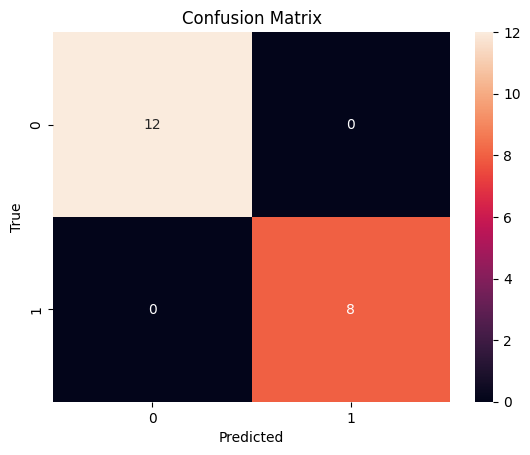

In [8]:
import seaborn as sns
X = df.drop('label', axis=1).values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Classification Report:\n', classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 4. Results


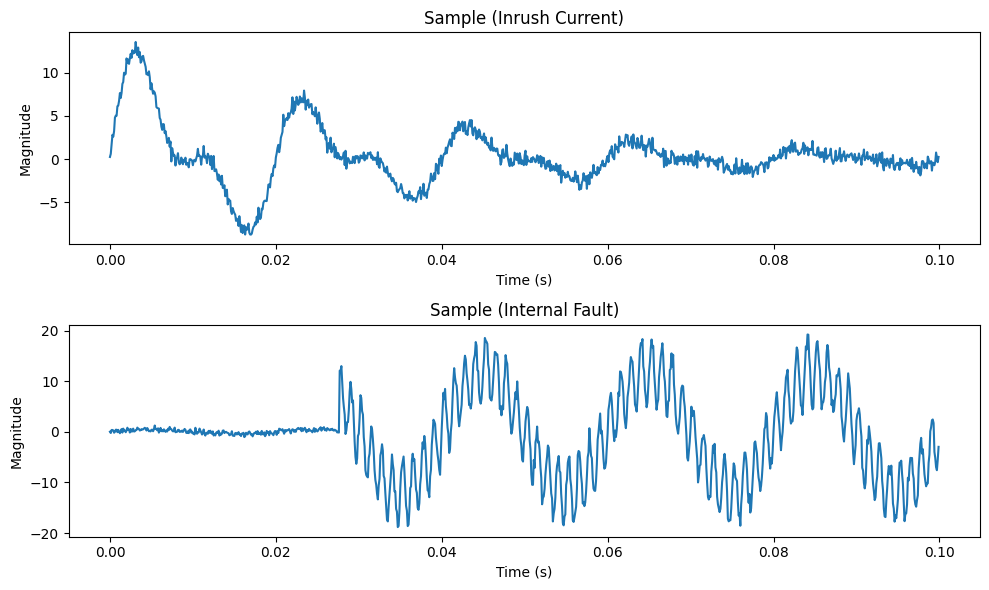

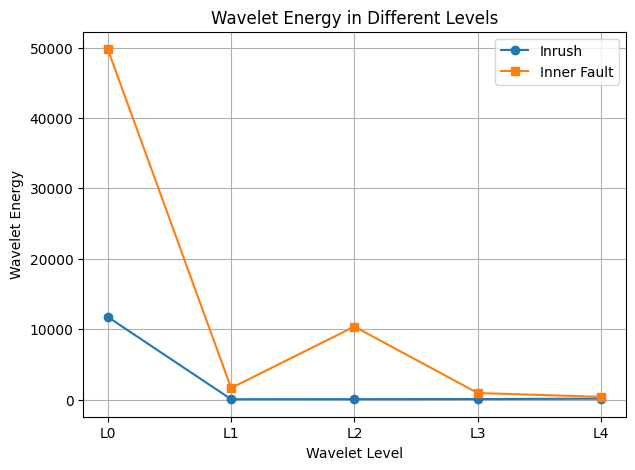

In [9]:

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(t, signals[0])
plt.title('Sample (Inrush Current)')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')

plt.subplot(2,1,2)
plt.plot(t, signals[-1])
plt.title('Sample (Internal Fault)')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()

# نمایش انرژی موجک در سطوح مختلف برای دو کلاس
mean_energies_inrush = np.mean(df[df['label']==0][[f'Energy_L{i}' for i in range(5)]].values, axis=0)
mean_energies_fault = np.mean(df[df['label']==1][[f'Energy_L{i}' for i in range(5)]].values, axis=0)

plt.figure(figsize=(7,5))
plt.plot(range(5), mean_energies_inrush, 'o-', label='Inrush')
plt.plot(range(5), mean_energies_fault, 's-', label='Inner Fault')
plt.xticks(range(5), [f'L{i}' for i in range(5)])
plt.ylabel('Wavelet Energy')
plt.xlabel('Wavelet Level')
plt.legend()
plt.title('Wavelet Energy in Different Levels')
plt.grid(True)
plt.show()


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# سیگنال نمونه (از داده‌های قبلی)
signal = signals[-1]

window_size = 200    # تعداد نقاط هر پنجره (مثلاً ۲۰ میلی‌ثانیه)
step_size = 100      # گام پنجره‌گذاری (۵۰ درصد overlap)
level = 1            # سطح موجک مورد نظر (L1=فرکانس بالا)

energies = []
times = []
for le in range(4):
  for start in range(0, len(signal) - window_size, step_size):
      window = signal[start:start+window_size]
      coeffs = pywt.wavedec(window, 'db4', level=4)
      energy = np.sum(np.square(coeffs[le]))
      energies.append(energy)
      # زمان میانی این پنجره
      times.append(t[start + window_size//2])
energies = np.array(energies)
energies = np.reshape(energies, (4, 8))
times = np.array(times)
times = np.reshape(times, (4, 8))

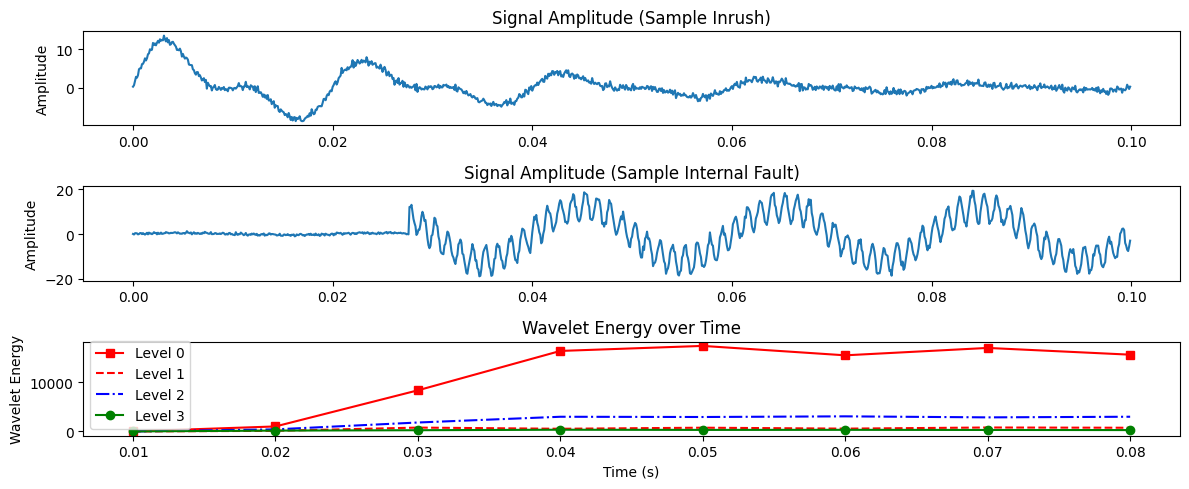

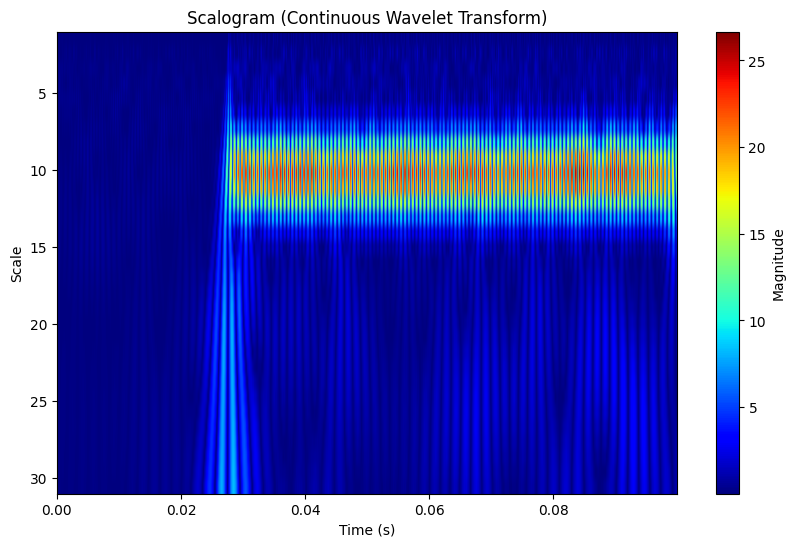

In [11]:

plt.figure(figsize=(12,5))
plt.subplot(3,1,1)
plt.plot(t, signals[0])
plt.title('Signal Amplitude (Sample Inrush)')
plt.ylabel('Amplitude')


plt.subplot(3,1,2)
plt.plot(t, signal)
plt.title('Signal Amplitude (Sample Internal Fault)')
plt.ylabel('Amplitude')

plt.subplot(3,1,3)
plt.plot(times[0, :], energies[0, :], color='r',  marker = 's',label = 'Level 0')
plt.plot(times[1, :], energies[1, :], color='red', linestyle='--', label = 'Level 1')
plt.plot(times[2, :], energies[2, :], color='b', linestyle='-.', label = 'Level 2')
plt.plot(times[3, :], energies[3, :], color='green', marker = 'o', label = 'Level 3')

plt.title('Wavelet Energy over Time')
plt.ylabel('Wavelet Energy')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.legend()
plt.show()

scales = np.arange(1, 32)
coeff, freq = pywt.cwt(signal, scales, 'morl')
plt.figure(figsize=(10,6))
plt.imshow(np.abs(coeff), extent=[t[0], t[-1], scales[-1], scales[0]],
           aspect='auto', cmap='jet')
plt.xlabel('Time (s)')
plt.ylabel('Scale')
plt.title('Scalogram (Continuous Wavelet Transform)')
plt.colorbar(label='Magnitude')
plt.show()

# **Real Case**
# Read PSCAD Data

In [13]:
import glob
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

files_dir = "/content/aaa"
out_files = glob.glob(os.path.join(files_dir, "*.out"))
dataframes = {}

def load_pscad_file(file_path):
    try:
        df = pd.read_csv(file_path, delim_whitespace=True, header=None, comment='#', skip_blank_lines=True)
        cols = ['Time'] + [f'Signal_{i}' for i in range(1, df.shape[1])]
        df.columns = cols
        return df
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

for f in out_files:
    name = os.path.splitext(os.path.basename(f))[0]
    df = load_pscad_file(f)
    if df is not None:
        dataframes[name] = df

df_summary = {k: v.shape for k, v in dataframes.items()}
print("---"*30)
print(df_summary)
print(df.shape)
df.head(5)


------------------------------------------------------------------------------------------
{'three fases ABC': (8001, 4), 'ABC Ground LV': (8001, 4), 'BC Ground LV': (8001, 4), 'C Ground LV': (8001, 4), 'two fases AB': (8001, 4), 'two fases AC': (8001, 4), 'B Ground LV': (8001, 4), 'AC Ground LV': (8001, 4), 'AB Ground LV': (8001, 4), 'two fases BC': (8001, 4), 'NO fault or inrush': (8001, 4), 'differential': (8001, 4)}
(8001, 4)


Time  Signal_1  Signal_2      Signal_3
0  0.0000  0.000004 -0.000004  1.058716e-07
1  0.0001  0.000003 -0.000004  9.024834e-08
2  0.0002  0.000003 -0.000003  6.722361e-08
3  0.0003  0.000003 -0.000003  4.768841e-08
4  0.0004  0.000002 -0.000002  2.617145e-08

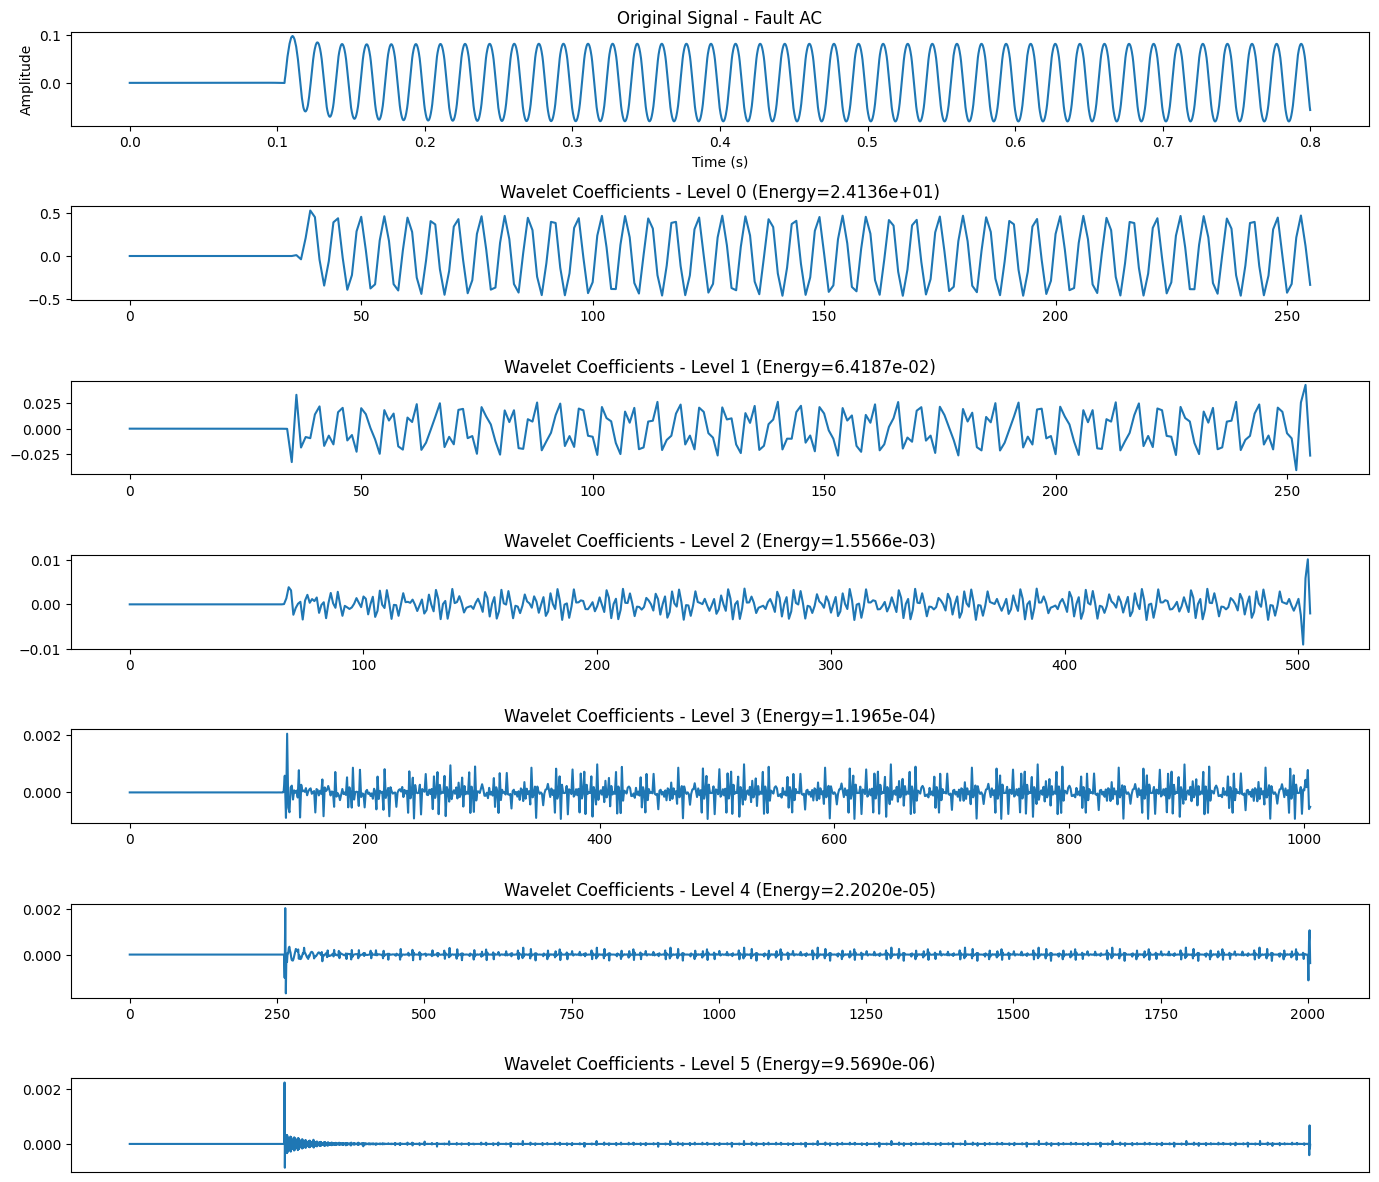

In [15]:


# --- Wavelet Analysis Function ---
def wavelet_analysis(df, signal_col='Signal_1', wavelet='db4', level=5, scenario_name='Scenario'):
    signal = df[signal_col].values

    # Apply DWT
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    # Calculate energy
    energies = [sum(c**2) for c in coeffs]

    plt.figure(figsize=(14, 12))
    plt.subplot(level+2, 1, 1)
    plt.plot(df['Time'], signal)
    plt.title(f'Original Signal - {scenario_name}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    for i, c in enumerate(coeffs):
        plt.subplot(level+2, 1, i+2)
        plt.plot(c)
        plt.title(f'Wavelet Coefficients - Level {i} (Energy={energies[i]:.4e})')
    plt.gca().get_xaxis().set_visible(False)

    plt.tight_layout()
    plt.show()

    return coeffs, energies

coeffs_diff, energies_diff = wavelet_analysis(dataframes['two fases AC'],
                                              signal_col='Signal_1',
                                              scenario_name='Fault AC')


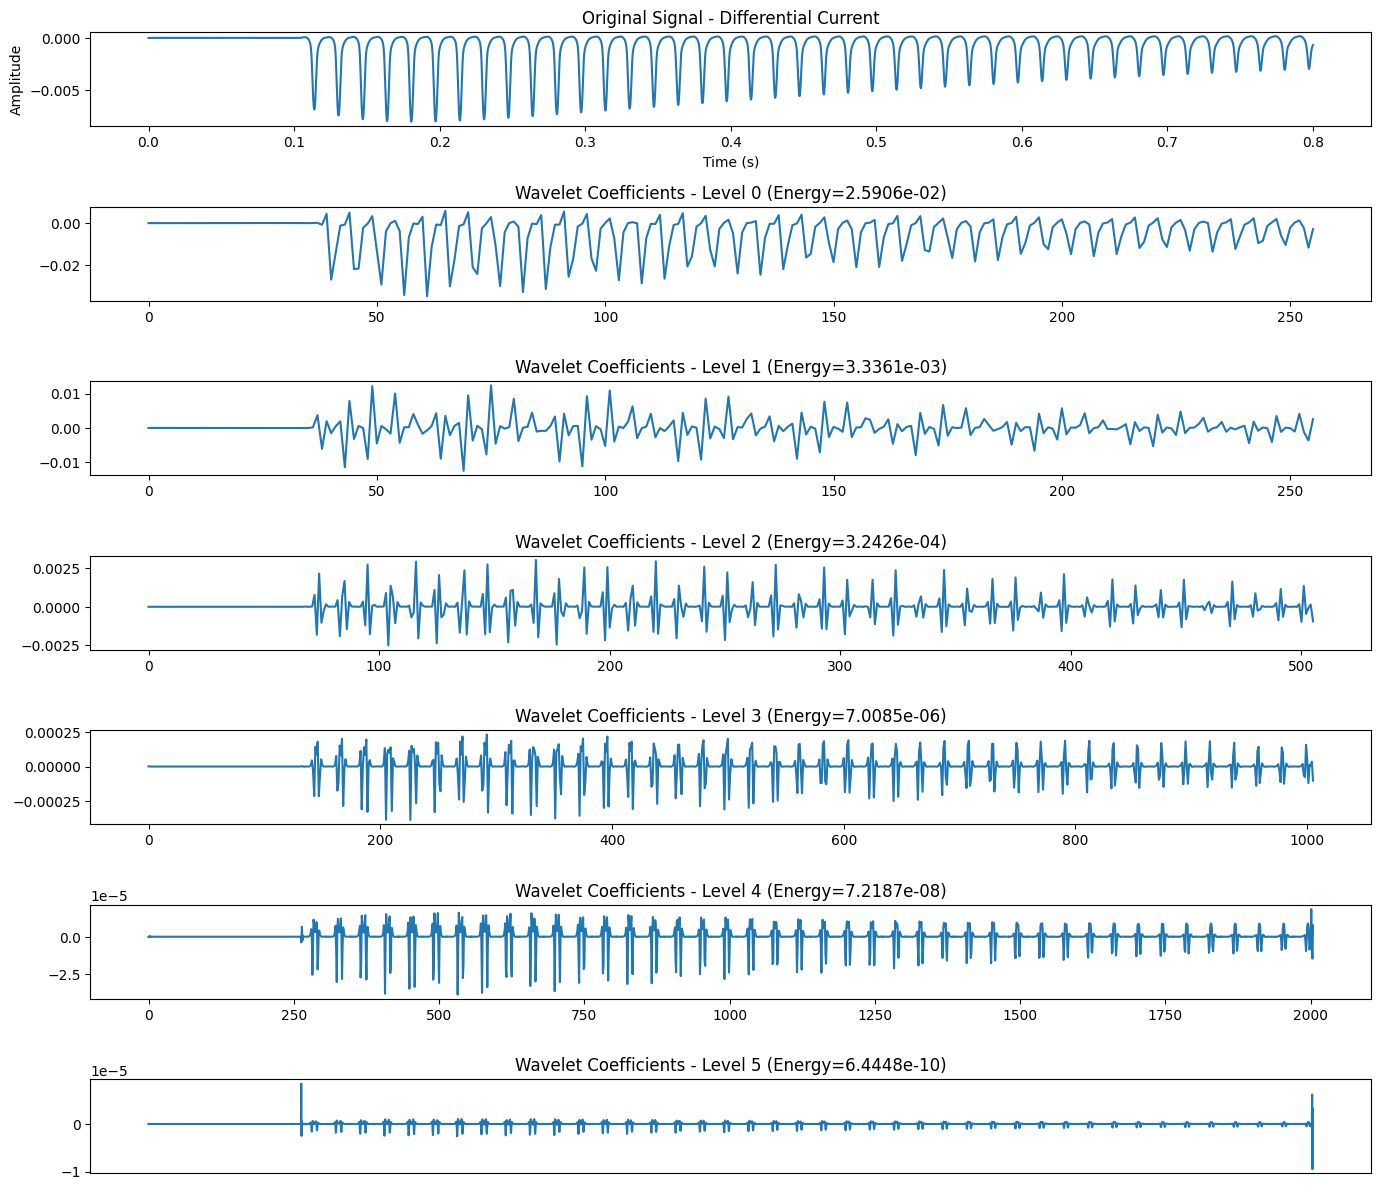

In [16]:
coeffs_diff, energies_diff = wavelet_analysis(dataframes['differential'],
                                              signal_col='Signal_2',
                                              scenario_name='Differential Current')

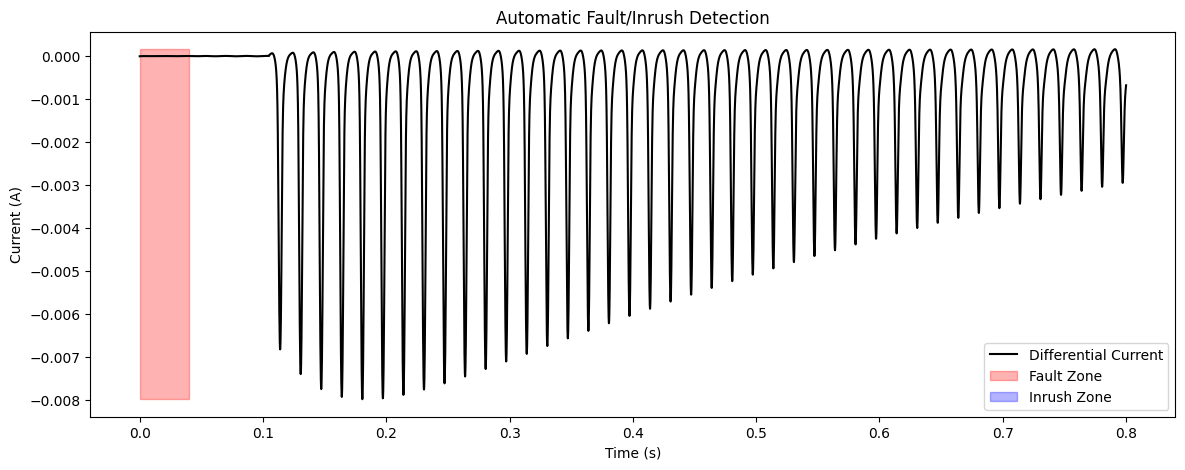

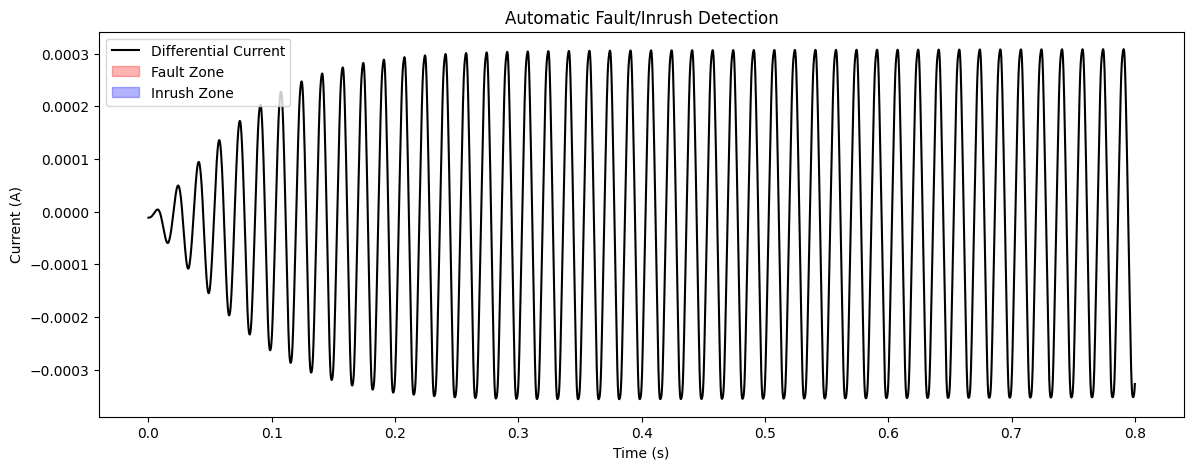

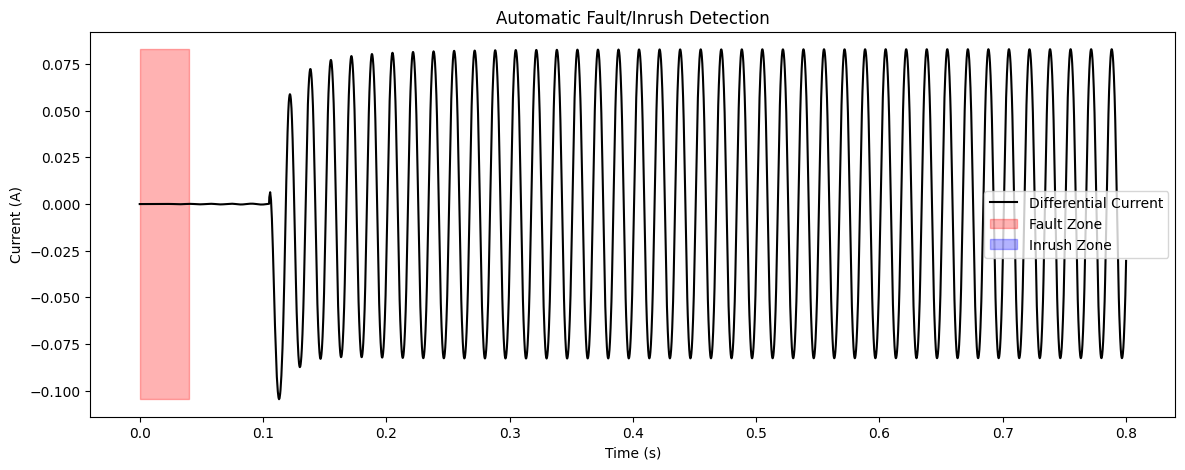

In [19]:

def classify_fault_inrush(df, signal_col='Signal_3', wavelet='db4', level=5, window=200):
    signal = df[signal_col].values

    # DWT
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    # Energies for levels
    energies = [np.array(c)**2 for c in coeffs]
    time = df['Time'].values
    classification = np.zeros(len(signal))  # 0 = normal, 1 = fault, 2 = inrush

    for i in range(0, len(signal)-window, window):
        e_high = np.sum(energies[0][i//(2**0):(i+window)//(2**0)])  # High freq
        e_low  = np.sum(energies[-1][i//(2**level):(i+window)//(2**level)])  # Low freq

        if e_high > 5e-4:  # Threshold for fault
            classification[i:i+window] = 1
        elif e_low > 1e-5:  # Threshold for inrush
            classification[i:i+window] = 2

    plt.figure(figsize=(14,5))
    plt.plot(time, signal, label='Differential Current', color='black')
    plt.fill_between(time, min(signal), max(signal), where=(classification==1), color='red', alpha=0.3, label='Fault Zone')
    plt.fill_between(time, min(signal), max(signal), where=(classification==2), color='blue', alpha=0.3, label='Inrush Zone')
    plt.title('Automatic Fault/Inrush Detection')
    plt.xlabel('Time (s)')
    plt.ylabel('Current (A)')
    plt.legend()
    plt.show()
    return classification

class_result = classify_fault_inrush(dataframes['differential'], signal_col='Signal_2')
class_result = classify_fault_inrush(dataframes['NO fault or inrush'], signal_col='Signal_2')
class_result = classify_fault_inrush(dataframes['two fases BC'], signal_col='Signal_2')


In [20]:
results_summary = []
def process_all_scenarios(data_dict, wavelet='db4', level=1, window=200):
    for scenario, df in data_dict.items():
        signal = df['Signal_1'].values
        time = df['Time'].values

        # Wavelet decomposition
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        energies = [np.array(c)**2 for c in coeffs]

        classification = np.zeros(len(signal))

        # Classification based on energy levels
        for i in range(0, len(signal)-window, window):
            e_high = np.sum(energies[0][i//(2**0):(i+window)//(2**0)])
            e_low  = np.sum(energies[-1][i//(2**level):(i+window)//(2**level)])

            if e_high > 5e-4:
                classification[i:i+window] = 1
            elif e_low > 1e-5:
                classification[i:i+window] = 2

        fault_intervals = []
        inrush_intervals = []
        current_state = 0
        start_time = None
        for idx, state in enumerate(classification):
            if state != current_state:
                if current_state == 1:
                    fault_intervals.append((start_time, time[idx]))
                elif current_state == 2:
                    inrush_intervals.append((start_time, time[idx]))
                if state != 0:
                    start_time = time[idx]
                current_state = state

        results_summary.append({
            "Scenario": scenario,
            "Fault Intervals": fault_intervals,
            "Inrush Intervals": inrush_intervals,
            "Detected": "Fault" if fault_intervals else ("Inrush" if inrush_intervals else "Normal")
        })

    return pd.DataFrame(results_summary)

df_re = process_all_scenarios(dataframes)
df_re

Scenario Fault Intervals Inrush Intervals Detected
0      three fases ABC  [(0.04, 0.42)]               []    Fault
1        ABC Ground LV  [(0.04, 0.42)]               []    Fault
2         BC Ground LV  [(0.04, 0.42)]               []    Fault
3          C Ground LV  [(0.04, 0.42)]               []    Fault
4         two fases AB              []               []   Normal
5         two fases AC  [(0.04, 0.42)]               []    Fault
6          B Ground LV              []               []   Normal
7         AC Ground LV  [(0.04, 0.42)]               []    Fault
8         AB Ground LV              []               []   Normal
9         two fases BC  [(0.04, 0.42)]               []    Fault
10  NO fault or inrush              []               []   Normal
11        differential   [(0.04, 0.4)]               []    Fault

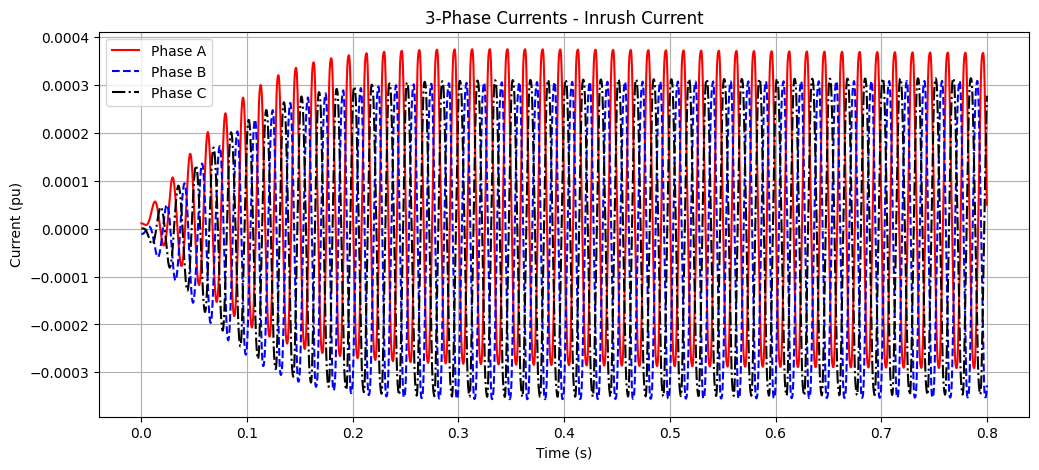

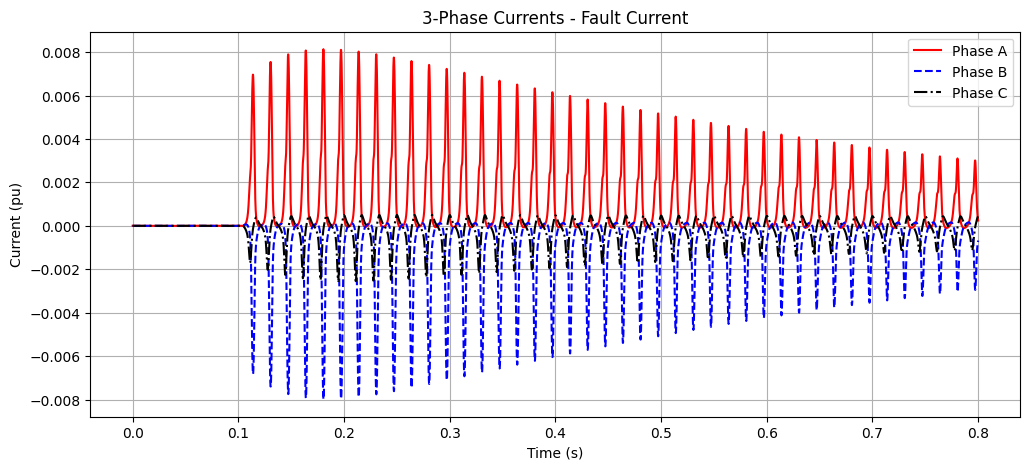

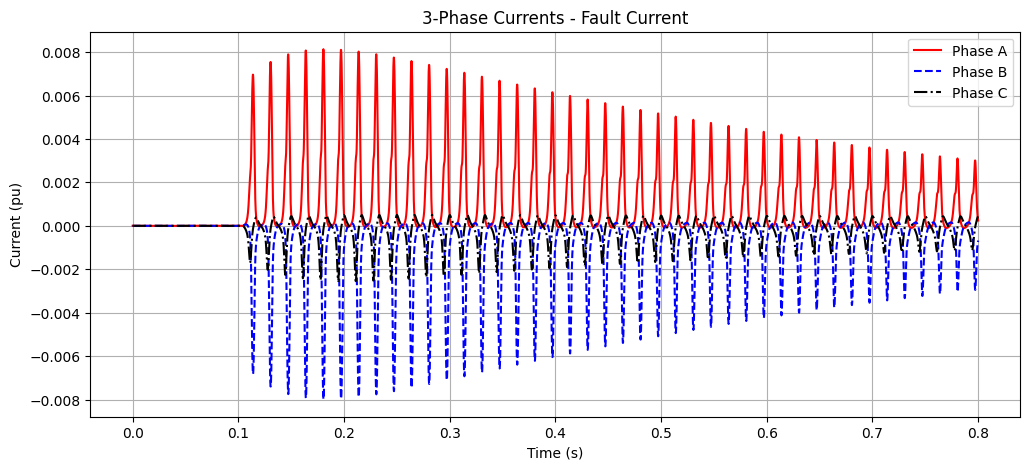

In [21]:
def plot_three_phase_currents(df, scenario_name="Scenario"):
    time = df['Time'].values
    phase_A = df['Signal_1'].values
    phase_B = df['Signal_2'].values
    phase_C = df['Signal_3'].values

    plt.figure(figsize=(12,5))
    plt.plot(time, phase_A, 'r', label='Phase A')
    plt.plot(time, phase_B, 'b--', label='Phase B')
    plt.plot(time, phase_C, 'k-.', label='Phase C')

    plt.title(f'3-Phase Currents - {scenario_name}')
    plt.xlabel('Time (s)')
    plt.ylabel('Current (pu)')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_three_phase_currents(dataframes['NO fault or inrush'], scenario_name="Inrush Current")
plot_three_phase_currents(dataframes['differential'], scenario_name="Fault Current")
plot_three_phase_currents(dataframes['differential'], scenario_name="Fault Current")


In [ ]:
import glob
import pandas as pd
import os

files_dir = "/content/aaa"
out_files = glob.glob(os.path.join(files_dir, "*.out"))

# Function to load PSCAD data
def load_pscad_file(file_path):
    try:
        df = pd.read_csv(file_path, delim_whitespace=True, header=None, comment='#', skip_blank_lines=True)
        cols = ['Time'] + [f'Signal_{i}' for i in range(1, df.shape[1])]
        df.columns = cols
        return df
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

# Loop over all files and save each one separately
for f in out_files:
    name = os.path.splitext(os.path.basename(f))[0]   # get filename without extension
    df = load_pscad_file(f)
    if df is not None:
        csv_path = os.path.join(files_dir, f"{name}.csv")
        df.to_csv(csv_path, index=False)
        print(f"Saved {csv_path}")

print("--- Done ---")


/tmp/ipython-input-4065496282.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None, comment='#', skip_blank_lines=True)
/tmp/ipython-input-4065496282.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None, comment='#', skip_blank_lines=True)


Saved /content/aaa/AB Ground LV.csv
Saved /content/aaa/B Ground LV.csv


/tmp/ipython-input-4065496282.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None, comment='#', skip_blank_lines=True)


Saved /content/aaa/AC Ground LV.csv
Saved /content/aaa/NO fault or inrush.csv


/tmp/ipython-input-4065496282.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None, comment='#', skip_blank_lines=True)
/tmp/ipython-input-4065496282.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None, comment='#', skip_blank_lines=True)


Saved /content/aaa/two fases AB.csv


/tmp/ipython-input-4065496282.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None, comment='#', skip_blank_lines=True)


Saved /content/aaa/three fases ABC.csv
Saved /content/aaa/differential.csv


/tmp/ipython-input-4065496282.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None, comment='#', skip_blank_lines=True)
/tmp/ipython-input-4065496282.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None, comment='#', skip_blank_lines=True)


Saved /content/aaa/C Ground LV.csv
Saved /content/aaa/ABC Ground LV.csv


/tmp/ipython-input-4065496282.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None, comment='#', skip_blank_lines=True)
/tmp/ipython-input-4065496282.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None, comment='#', skip_blank_lines=True)


Saved /content/aaa/two fases BC.csv


/tmp/ipython-input-4065496282.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None, comment='#', skip_blank_lines=True)


Saved /content/aaa/BC Ground LV.csv
Saved /content/aaa/two fases AC.csv
--- Done ---


/tmp/ipython-input-4065496282.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None, comment='#', skip_blank_lines=True)


In [22]:
import glob
import pandas as pd
import os
import numpy as np
import pywt

files_dir = "/content/aaa"
out_files = glob.glob(os.path.join(files_dir, "*.out"))
dataframes = {}

# Function to load PSCAD data
def load_pscad_file(file_path):
    try:
        df = pd.read_csv(file_path, delim_whitespace=True, header=None, comment='#', skip_blank_lines=True)
        cols = ['Time'] + [f'Signal_{i}' for i in range(1, df.shape[1])]
        df.columns = cols
        return df
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

for f in out_files:
    name = os.path.splitext(os.path.basename(f))[0]
    df = load_pscad_file(f)
    if df is not None:
        dataframes[name] = df

df_summary = {k: v.shape for k, v in dataframes.items()}
print(df_summary)
print("---"*30)
print(f"The shape of df = {df.shape}")
df.to_csv('AllPSCADdata.csv', index=False)
df.head(5)

{'three fases ABC': (8001, 4), 'ABC Ground LV': (8001, 4), 'BC Ground LV': (8001, 4), 'C Ground LV': (8001, 4), 'two fases AB': (8001, 4), 'two fases AC': (8001, 4), 'B Ground LV': (8001, 4), 'AC Ground LV': (8001, 4), 'AB Ground LV': (8001, 4), 'two fases BC': (8001, 4), 'NO fault or inrush': (8001, 4), 'differential': (8001, 4)}
------------------------------------------------------------------------------------------
The shape of df = (8001, 4)


Time  Signal_1  Signal_2      Signal_3
0  0.0000  0.000004 -0.000004  1.058716e-07
1  0.0001  0.000003 -0.000004  9.024834e-08
2  0.0002  0.000003 -0.000003  6.722361e-08
3  0.0003  0.000003 -0.000003  4.768841e-08
4  0.0004  0.000002 -0.000002  2.617145e-08

# کل مدل به صورت یکجا

--- محاسبه انرژی‌های موجک برای هر سیگنال ---


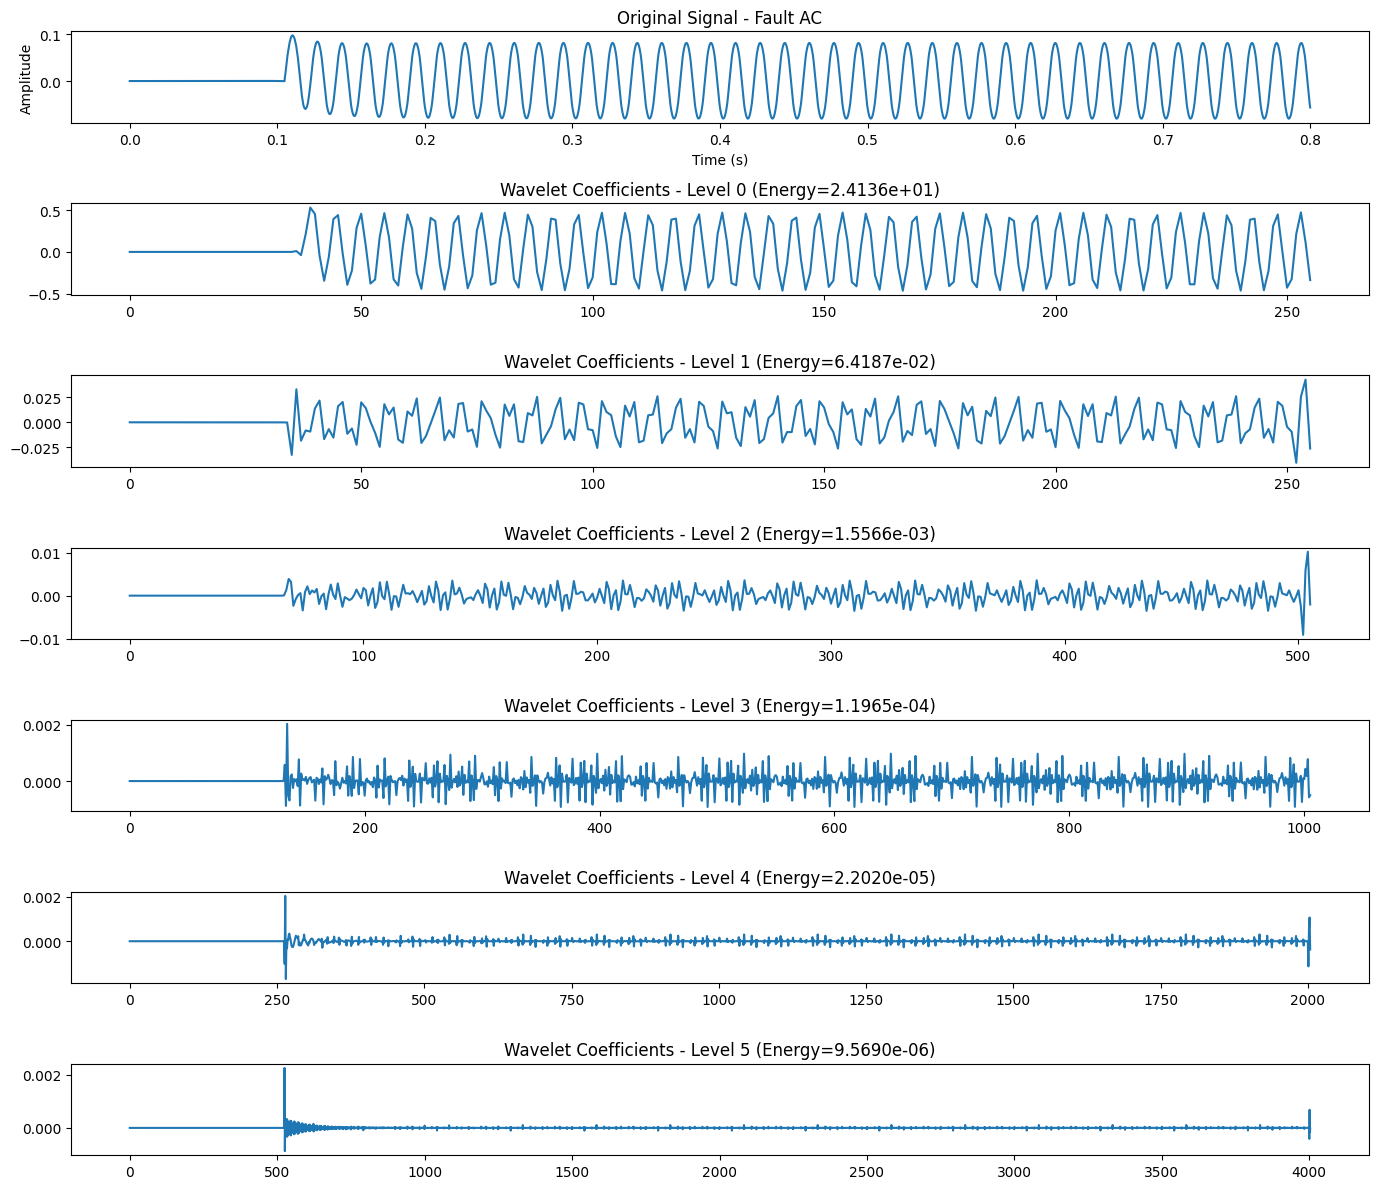

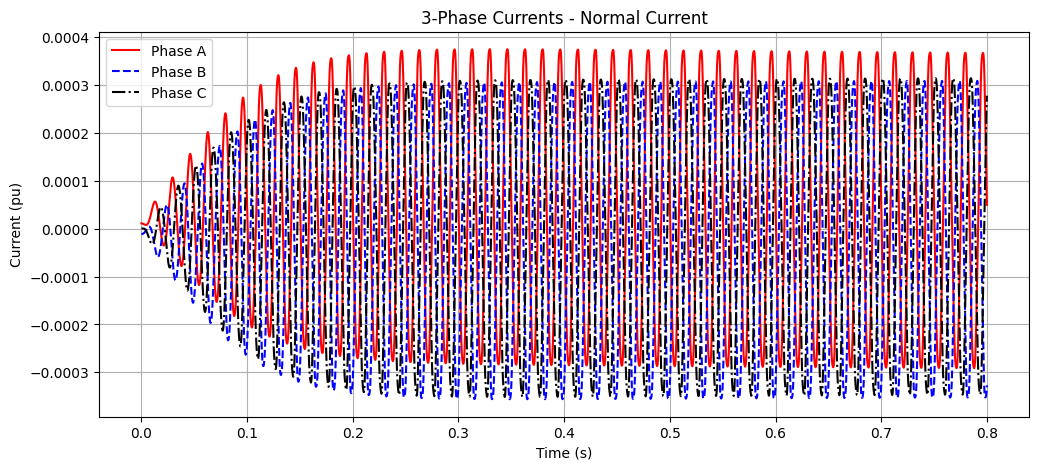

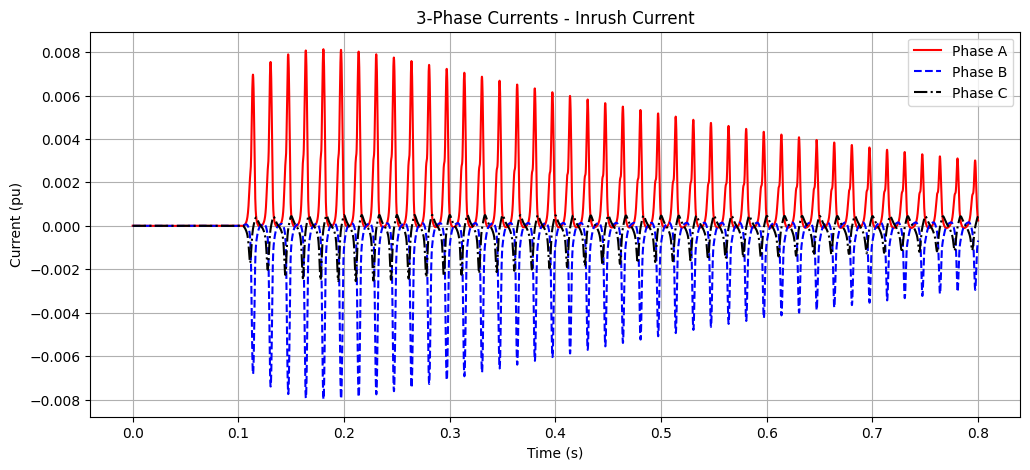

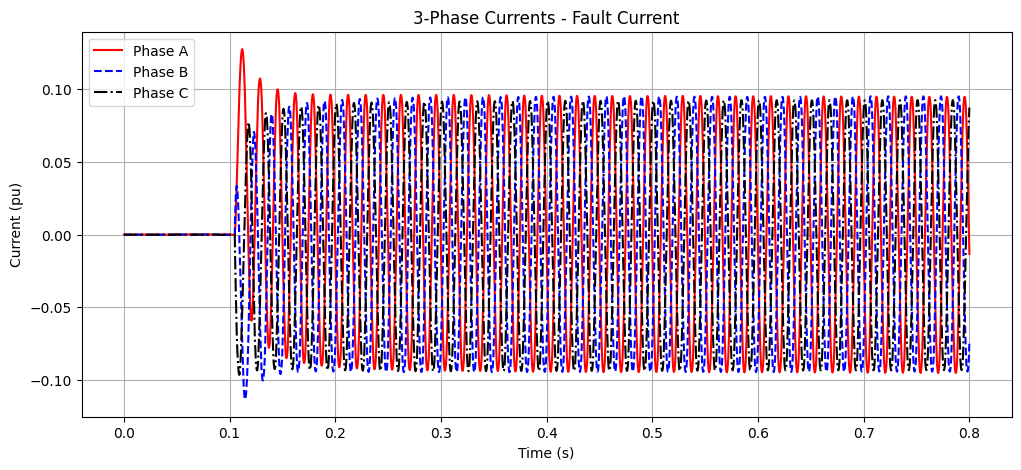

File True Label  High_Freq_Energy  Low_Freq_Energy  \
0         differential     Inrush        6.7406e-10       3.3149e-04   
1      three fases ABC      Fault        6.1601e-15       2.2398e-12   
2         two fases AB      Fault        8.0179e-15       7.5361e-12   
3         AB Ground LV      Fault        2.2175e-07       8.4763e-06   
4          C Ground LV      Fault        2.9007e-07       2.7927e-05   
5         two fases BC      Fault        2.4368e-15       5.2213e-12   
6   NO fault or inrush     Normal        1.8072e-15       7.0931e-11   
7          B Ground LV      Fault        4.4396e-06       5.8319e-05   
8         two fases AC      Fault        3.7284e-15       5.9641e-12   
9         BC Ground LV      Fault        3.4056e-06       6.9930e-06   
10        AC Ground LV      Fault        2.4995e-06       1.6362e-05   
11       ABC Ground LV      Fault        6.7816e-09       4.7946e-08   

    Mean_Freq_Energy_All_Levels  Len_Coeffs  
0                    5.8811e-03           6  
1                    1.2249e-11           6  
2                    1.1947e-10           6  
3                    8.0578e-02           6  
4                    2.5175e-01           6  
5                    2.0871e-10           6  
6                    4.0856e-10           6  
7                    2.6100e-01           6  
8                    2.0457e-10           6  
9                    7.9974e-02           6  
10                   7.6638e-02           6  
11                   3.9921e-06           6

In [ ]:
import numpy as np
import pywt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import os

# ===================================================================
# Read PSCAD Data (with the shape of (8001, 4))
# ===================================================================

df = pd.read_csv('/content/AllPSCADdata.csv')
def get_wavelet_energies(signal, wavelet='db4', level=5):
    '''
    Get Wavelet Energy for High and Low Frequencies
    '''
    if signal is None or len(signal) < 100:
        return None, None
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    len_coeffs = len(coeffs)
    high_freq_energy = np.sum(np.square(coeffs[-1]))
    low_freq_energy = np.sum(np.square(coeffs[2])) # cD4
    mean_freq_energy_all_levels = np.mean([np.sum(np.square(c)) for c in coeffs])
    return high_freq_energy, low_freq_energy, mean_freq_energy_all_levels, len_coeffs

true_labels_map = {
    'AB Ground LV': "Fault", 'ABC Ground LV': "Fault", 'AC Ground LV': "Fault",
    'B Ground LV': "Fault", 'BC Ground LV': "Fault", 'C Ground LV': "Fault",
    'three fases ABC': "Fault", 'two fases AB': "Fault", 'two fases BC': "Fault",
    'two fases AC': "Fault", 'differential': "Inrush",
    'NO fault or inrush': "Normal"
}
energy_results = []
print("--- محاسبه انرژی‌های موجک برای هر سیگنال ---")
for name, df in dataframes.items():
    if df.shape[1] < 4:
        continue
    phase_A = df['Signal_1'].to_numpy()
    phase_B = df['Signal_2'].to_numpy()
    phase_C = df['Signal_3'].to_numpy()
    true_label = true_labels_map.get(name, "Unknown")
    if true_label == 'Inrush':
        signal_to_analyze = phase_A
    else:
        signal_to_analyze = phase_A + phase_B + phase_C
    # HFE indicates High-Frequency Energy
    # LFE indicates Low-Frequency Energy
    hfe, lfe, mean_freq_energy_all_levels, len_coeffs = get_wavelet_energies(signal_to_analyze)
    if hfe is not None:
        energy_results.append({
            "File": name,
            "True Label": true_label,
            "High_Freq_Energy": hfe,
            "Low_Freq_Energy": lfe,
            "Mean_Freq_Energy_All_Levels": mean_freq_energy_all_levels,
            "Len_Coeffs": len_coeffs
        })

energy_df = pd.DataFrame(energy_results)

# ===================================================================
# Plot some figures
# ===================================================================
def wavelet_analysis(df, signal_col='Signal_1', wavelet='db4', level=5, scenario_name='Scenario'):
    signal = df[signal_col].values
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    energies = [sum(c**2) for c in coeffs]
    plt.figure(figsize=(14, 12))
    plt.subplot(level+2, 1, 1)
    plt.plot(df['Time'], signal)
    plt.title(f'Original Signal - {scenario_name}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    for i, c in enumerate(coeffs):
        plt.subplot(level+2, 1, i+2)
        plt.plot(c)
        plt.title(f'Wavelet Coefficients - Level {i} (Energy={energies[i]:.4e})')
    plt.tight_layout()
    plt.show()
    return coeffs, energies
coeffs_diff, energies_diff = wavelet_analysis(dataframes['two fases AC'],signal_col='Signal_1',scenario_name='Fault AC')

def plot_three_phase_currents(df, scenario_name="Scenario"):
    time = df['Time'].values
    phase_A = df['Signal_1'].values
    phase_B = df['Signal_2'].values
    phase_C = df['Signal_3'].values
    plt.figure(figsize=(12,5))
    plt.plot(time, phase_A, 'r', label='Phase A')
    plt.plot(time, phase_B, 'b--', label='Phase B')
    plt.plot(time, phase_C, 'k-.', label='Phase C')
    plt.title(f'3-Phase Currents - {scenario_name}')
    plt.xlabel('Time (s)')
    plt.ylabel('Current (pu)')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_three_phase_currents(dataframes['NO fault or inrush'], scenario_name="Normal Current")
plot_three_phase_currents(dataframes['differential'], scenario_name="Inrush Current")
plot_three_phase_currents(dataframes['three fases ABC'], scenario_name="Fault Current")

energy_df

In [ ]:

# ===================================================================
# بخش ۱: توابع کمکی و تحلیلی
# ===================================================================

def get_wavelet_features(signal, level=5, wavelet='db4'):
    if signal is None or len(signal) < 2**(level+1):
        return None
    try:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        cD1 = coeffs[-1]
        cD4 = coeffs[2]

        hfe = np.sum(np.square(cD1))
        lfe = np.sum(np.square(cD4))

        # پیدا کردن اندیس ضریبی که بیشترین دامنه را دارد
        spike_coeff_index = np.argmax(np.abs(cD1))
        # ضریب cD1 با کاهش نمونه‌برداری ۲ تولید شده، پس اندیس آن را در ۲ ضرب می‌کنیم
        spike_time_index = spike_coeff_index * (2**1)

        if spike_time_index >= len(signal):
            spike_time_index = len(signal) - 1

        return {
            "hfe": hfe,
            "lfe": lfe,
            "spike_time_index": spike_time_index,
            "spike_amplitude": signal[spike_time_index],
            "coeffs_D1": cD1
        }
    except Exception:
        return None

def diagnose_signal_detailed(phases, time_vector):
    FAULT_THRESHOLD = 1e-8
    INRUSH_THRESHOLD = 1e-4

    features = {}
    for i, phase_name in enumerate(['A', 'B', 'C']):
        features[phase_name] = get_wavelet_features(phases[i])
        if features[phase_name] is None:
            return {"prediction": "Invalid Signal"}

    # پیدا کردن حداکثر انرژی‌ها در بین سه فاز
    max_hfe = max(f['hfe'] for f in features.values())
    max_lfe = max(f['lfe'] for f in features.values())

    # منطق تشخیص
    if max_hfe > FAULT_THRESHOLD:
        # پیدا کردن فازی که باعث تشخیص خطا شده است
        faulty_phase = max(features, key=lambda p: features[p]['hfe'])
        details = features[faulty_phase]
        event_time = time_vector[details['spike_time_index']]

        return {
            "prediction": "Fault", "metric": "HFE", "value": max_hfe,
            "event_time": event_time, "event_amplitude": details['spike_amplitude'],
            "event_phase": faulty_phase, "coeffs": features
        }

    if max_lfe > INRUSH_THRESHOLD:
        # جریان هجومی معمولا در LFE فاز A یا هر سه فاز دیده می‌شود
        inrush_phase = max(features, key=lambda p: features[p]['lfe'])
        details = features[inrush_phase]

        return {
            "prediction": "Inrush", "metric": "LFE", "value": max_lfe,
            "event_time": None, "event_amplitude": None, # زمان برای هجومی معنی‌دار نیست
            "event_phase": inrush_phase, "coeffs": features
        }

    return {"prediction": "Normal", "metric": "None", "value": None,
            "event_time": None, "event_amplitude": None, "event_phase": None, "coeffs": features}

# ===================================================================
# بخش ۲: تابع رسم نمودارها
# ===================================================================

def plot_diagnostic_chart(time, phases, diagnosis, filename):
    pred = diagnosis['prediction']
    if pred == "Normal":
        return

    fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    fig.suptitle(f"Diagnostic Chart for: {filename}\nPrediction: {pred}", fontsize=16, weight='bold')

    # --- پنل بالا: سیگنال‌های سه فاز ---
    axs[0].plot(time, phases[0], label='Phase A', color='r')
    axs[0].plot(time, phases[1], label='Phase B', color='g')
    axs[0].plot(time, phases[2], label='Phase C', color='b')
    axs[0].set_title('Three-Phase Currents')
    axs[0].set_ylabel('Amplitude')
    axs[0].grid(True)
    axs[0].legend()

    # --- پنل پایین: ضرایب موجک (cD1) ---
    coeffs = diagnosis['coeffs']
    axs[1].plot(coeffs['A']['coeffs_D1'], label='cD1 - Phase A', color='r', alpha=0.8)
    axs[1].plot(coeffs['B']['coeffs_D1'], label='cD1 - Phase B', color='g', alpha=0.8)
    axs[1].plot(coeffs['C']['coeffs_D1'], label='cD1 - Phase C', color='b', alpha=0.8)
    axs[1].set_title('Wavelet Detail Coefficients (cD1) - High Frequency Components')
    axs[1].set_ylabel('Coefficient Value')
    axs[1].set_xlabel('Coefficient Index')
    axs[1].grid(True)
    axs[1].legend()

    if pred == "Fault":
        event_time = diagnosis['event_time']
        axs[0].axvline(x=event_time, color='black', linestyle='--', linewidth=2, label=f'Event at {event_time:.4f}s')
        info_text = (f"Reason: High-Frequency Energy > Threshold\n"
                     f"Fault detected on Phase: {diagnosis['event_phase']}\n"
                     f"Time: {diagnosis['event_time']:.4f} s\n"
                     f"Amplitude: {diagnosis['event_amplitude']:.2f}")
        axs[0].text(0.98, 0.95, info_text, transform=axs[0].transAxes, fontsize=10,
                    verticalalignment='top', horizontalalignment='right',
                    bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.8))
        axs[0].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    output_filename = f"./res/Figure_{filename.replace(' ', '_')}.png"
    plt.savefig(output_filename)
    plt.close(fig)
    print(f" -> Diagnostic chart saved to '{output_filename}'")

# ===================================================================
# بخش ۳: اسکریپت اصلی اجرا
# ===================================================================
if 'dataframes' not in locals():
    print("No DataFrame Found")
else:
    true_labels_map = {
        'AB Ground LV': "Fault", 'ABC Ground LV': "Fault", 'AC Ground LV': "Fault",
        'B Ground LV': "Fault", 'BC Ground LV': "Fault", 'C Ground LV': "Fault",
        'three fases ABC': "Fault", 'two fases AB': "Fault", 'two fases BC': "Fault",
        'two fases AC': "Fault", 'differential': "Inrush",
        'NO fault or inrush': "Normal"
    }
    detailed_results = []
    print("--- شروع تحلیل ---")
    for name, df in dataframes.items():
        if df.shape[1] < 4: continue
        time_vec = df['Time'].to_numpy()
        phases = [df['Signal_1'].to_numpy(), df['Signal_2'].to_numpy(), df['Signal_3'].to_numpy()]
        diagnosis = diagnose_signal_detailed(phases, time_vec)
        true_label = true_labels_map.get(name, "Unknown")
        detailed_results.append({
            "File": name,
            "True Label": true_label,
            "Prediction": diagnosis.get('prediction'),
            "Decision Metric": diagnosis.get('metric'),
            "Metric Value": diagnosis.get('value'),
            "Event Time (s)": diagnosis.get('event_time'),
            "Event Amplitude": diagnosis.get('event_amplitude'),
            "Event Phase": diagnosis.get('event_phase'),
        })
        plot_diagnostic_chart(time_vec, phases, diagnosis, name)
    results_df = pd.DataFrame(detailed_results)
    print("\n--- جدول کامل نتایج تحلیل ---")
    pd.options.display.float_format = '{:.4e}'.format
    print(results_df)

    y_true = results_df["True Label"]
    y_pred = results_df["Prediction"]
    labels = sorted(list(set(y_true) | set(y_pred)))
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_df = pd.DataFrame(cm, index=[f"واقعی: {l}" for l in labels], columns=[f"تشخیص: {l}" for l in labels])
    print(f"\nدقت کلی الگوریتم: {accuracy * 100:.2f}%\n")
    print("--- ماتریس درهم‌ریختگی ---")
    print(cm_df)

--- شروع تحلیل ---
 -> Diagnostic chart saved to './res/Figure_differential.png'
 -> Diagnostic chart saved to './res/Figure_three_fases_ABC.png'
 -> Diagnostic chart saved to './res/Figure_two_fases_AB.png'
 -> Diagnostic chart saved to './res/Figure_AB_Ground_LV.png'
 -> Diagnostic chart saved to './res/Figure_C_Ground_LV.png'
 -> Diagnostic chart saved to './res/Figure_two_fases_BC.png'
 -> Diagnostic chart saved to './res/Figure_B_Ground_LV.png'
 -> Diagnostic chart saved to './res/Figure_two_fases_AC.png'
 -> Diagnostic chart saved to './res/Figure_BC_Ground_LV.png'
 -> Diagnostic chart saved to './res/Figure_AC_Ground_LV.png'
 -> Diagnostic chart saved to './res/Figure_ABC_Ground_LV.png'

--- جدول کامل نتایج تحلیل ---
                  File True Label Prediction Decision Metric  Metric Value  \
0         differential     Inrush     Inrush             LFE    3.3149e-04   
1      three fases ABC      Fault      Fault             HFE    2.9777e-05   
2         two fases AB      Faul

In [ ]:
results_df

File True Label Prediction Decision Metric  Metric Value  \
0         differential     Inrush     Inrush             LFE    3.3149e-04   
1      three fases ABC      Fault      Fault             HFE    2.9777e-05   
2         two fases AB      Fault      Fault             HFE    2.1745e-05   
3         AB Ground LV      Fault      Fault             HFE    2.1416e-05   
4          C Ground LV      Fault      Fault             HFE    2.9167e-07   
5         two fases BC      Fault      Fault             HFE    5.4292e-06   
6   NO fault or inrush     Normal     Normal            None           NaN   
7          B Ground LV      Fault      Fault             HFE    4.4276e-06   
8         two fases AC      Fault      Fault             HFE    9.5690e-06   
9         BC Ground LV      Fault      Fault             HFE    7.9920e-06   
10        AC Ground LV      Fault      Fault             HFE    1.1768e-05   
11       ABC Ground LV      Fault      Fault             HFE    2.6522e-05   

    Event Time (s)  Event Amplitude Event Phase  
0              NaN              NaN           A  
1       1.0500e-01      -9.3423e-03           C  
2       1.0500e-01       8.8205e-03           B  
3       1.0500e-01      -8.8140e-03           C  
4       1.0500e-01       7.3508e-04           A  
5       1.0500e-01      -3.1230e-03           A  
6              NaN              NaN        None  
7       1.0500e-01       3.7599e-03           B  
8       1.0500e-01       5.2701e-03           A  
9       1.0500e-01       4.4731e-03           B  
10      1.0500e-01      -6.5292e-03           C  
11      1.0500e-01      -9.2282e-03           C